In [792]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD

np.random.seed(0)

### Book  Dataset
https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset


In [793]:
rating_df = pd.read_csv('Ratings.csv')

rating_df.head(5)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [794]:
book_df = pd.read_csv('Books.csv')

#book_df.drop(['Image-URL-S', 'Image-URL-M','Image-URL-L'], axis=1,inplace=True)

C:\Users\cseka\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [795]:
book_df.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [796]:
book_df.describe()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271359,271360,271358,271360,271360,271357
unique,271360,242135,102023,202,16807,271044,271044,271041
top,0563207736,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/059045367X.0...,http://images.amazon.com/images/P/019282760X.0...,http://images.amazon.com/images/P/043908413X.0...
freq,1,27,632,13903,7535,2,2,2


### EDA on Rating dataset
- This dataset contain user rating information which will be very handy for recommendation system

In [797]:
rating_df.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [798]:
rating_df = rating_df.merge(book_df,on='ISBN')

<AxesSubplot:>

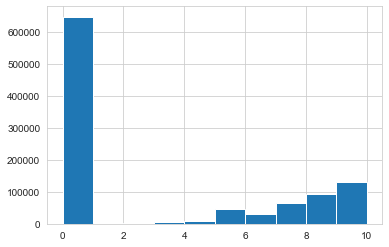

In [799]:
rating_df['Book-Rating'].hist()

### Also as we are considering book rating , we will consider rating given by avid book readers.So lets put some threshold on rating count given by users

In [800]:
x = rating_df.groupby('User-ID').count()['Book-Rating'] > 150
userIndex = x[x].index
nm_rating_df=rating_df[rating_df['User-ID'].isin(userIndex)]

In [801]:
y = nm_rating_df.groupby('Book-Title').count()['Book-Rating']>=40
books = y[y].index

In [802]:
final_ratings = nm_rating_df[nm_rating_df['Book-Title'].isin(books)]


### User Dataset

In [803]:
users_df = pd.read_csv('Users.csv')

users_df.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


# Popularity Based recommendation

### Avarage rating

In [804]:
avg_rating_df = final_ratings.groupby('Book-Title').mean()['Book-Rating'].reset_index()
avg_rating_df.rename(columns={'Book-Rating':'avg_rating'},inplace=True)
avg_rating_df.sort_values('avg_rating', ascending=[False]).head(10)

,Book-Title,avg_rating
403,Harry Potter and the Sorcerer's Stone (Book 1),5.166667
1025,The Little Prince,4.981818
8,84 Charing Cross Road,4.963636
402,Harry Potter and the Prisoner of Azkaban (Book 3),4.641026
400,Harry Potter and the Goblet of Fire (Book 4),4.566434
1033,The Lunatic Cafe (Anita Blake Vampire Hunter (...,4.550000
401,Harry Potter and the Order of the Phoenix (Boo...,4.333333
881,The Book of Questions,4.200000
1104,The Secret Garden,4.176471
164,Carrie,4.150000


### Total rating count

In [805]:
total_rating_df = ratings_with_name.groupby('Book-Title').count()['Book-Rating'].reset_index()
total_rating_df.rename(columns={'Book-Rating':'num_ratings'},inplace=True)
total_rating_df.sort_values('num_ratings', ascending=[False]).head(10)

,Book-Title,num_ratings
5440,Bridget Jones's Diary,30
14580,Harry Potter and the Chamber of Secrets (Book 2),25
14589,Harry Potter and the Prisoner of Azkaban (Book 3),25
14583,Harry Potter and the Goblet of Fire (Book 4),25
10168,Dreamcatcher,24
35804,The Lovely Bones: A Novel,24
37946,The Secret Garden,23
36615,The Notebook,21
24825,Pet Sematary,21
16989,It,21


In [806]:
popular_books_list = total_rating_df.merge(avg_rating_df,on='Book-Title')
popular_books_list.sort_values(['avg_rating','num_ratings'], ascending=[False,False]).head(10)

,Book-Title,num_ratings,avg_rating
400,Harry Potter and the Sorcerer's Stone (Book 1),19,5.166667
1015,The Little Prince,4,4.981818
8,84 Charing Cross Road,12,4.963636
399,Harry Potter and the Prisoner of Azkaban (Book 3),25,4.641026
397,Harry Potter and the Goblet of Fire (Book 4),25,4.566434
1023,The Lunatic Cafe (Anita Blake Vampire Hunter (...,5,4.550000
398,Harry Potter and the Order of the Phoenix (Boo...,20,4.333333
872,The Book of Questions,4,4.200000
1093,The Secret Garden,23,4.176471
161,Carrie,12,4.150000


### Plot the simple mean against the number of reviews 

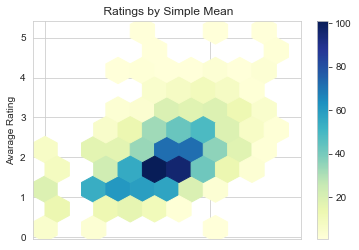

In [807]:
grid   = pd.DataFrame({
                    'Avarage Rating': popular_books_list['avg_rating'],
                    'Number of Reviewers': popular_books_list['num_ratings']
                 })
grid.plot(x='Number of Reviewers', y='Avarage Rating', kind='hexbin',
                  xscale='log', cmap='YlGnBu', gridsize=10, mincnt=1,
                  title=" Ratings by Simple Mean")
plt.show()


This figure shows that the average rating of a movie is actually slightly Lesser than 3

 ### Bayesian Adjustment Rating
 https://www.analyticsvidhya.com/blog/2019/07/introduction-online-rating-systems-bayesian-adjusted-rating/

In [808]:
bayes_adj_df=popular_books_list
bayes_adj_df['total']=bayes_adj_df['num_ratings']*bayes_adj_df['avg_rating']

In [809]:
total=bayes_adj_df['total'].sum()
total_views=bayes_adj_df['num_ratings'].sum()

In [810]:
bayes_adj_df['bayes_rating']=((bayes_adj_df['num_ratings']*bayes_adj_df['avg_rating'])+total)/((bayes_adj_df['num_ratings']+total_views))

In [811]:
bayes_adj_df.sort_values(['bayes_rating'], ascending=[False]).head(10)

,Book-Title,num_ratings,avg_rating,total,bayes_rating
399,Harry Potter and the Prisoner of Azkaban (Book 3),25,4.641026,116.025641,2.229321
397,Harry Potter and the Goblet of Fire (Book 4),25,4.566434,114.160839,2.229078
400,Harry Potter and the Sorcerer's Stone (Book 1),19,5.166667,98.166667,2.228735
396,Harry Potter and the Chamber of Secrets (Book 2),25,4.060302,101.507538,2.227424
1093,The Secret Garden,23,4.176471,96.058824,2.227294
398,Harry Potter and the Order of the Phoenix (Boo...,20,4.333333,86.666667,2.226940
8,84 Charing Cross Road,12,4.963636,59.563636,2.225724
1171,To Kill a Mockingbird,19,3.615385,68.692308,2.224880
1022,The Lovely Bones: A Novel,24,3.242902,77.829653,2.224620
47,A Wrinkle in Time,14,3.965517,55.517241,2.224612


# Colaborative Filtering

In [812]:
from scipy.sparse import csr_matrix
# pivot ratings into movie features
book_features_df = final_ratings.pivot_table(
    index='Book-Title',
    columns='User-ID',
    values='Book-Rating'
).fillna(0)
# convert dataframe of movie features to scipy sparse matrix

In [813]:
book_features_df

User-ID,254,1733,1903,2033,2110,2276,2766,2891,2977,3363,...,274301,274308,274808,275970,276680,277427,277478,277639,278188,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
16 Lighthouse Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010: Odyssey Two,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204 Rosewood Lane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Apply nearest neighbour Algorithms

In [814]:
from scipy.sparse import csr_matrix

book_features_df_matrix = csr_matrix(book_features_df.values)

from sklearn.neighbors import NearestNeighbors


model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(book_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [815]:
book_df[book_df['Book-Title']=='1984'].head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
2104,0451524934,1984,George Orwell,1990,Signet Book,http://images.amazon.com/images/P/0451524934.0...,http://images.amazon.com/images/P/0451524934.0...,http://images.amazon.com/images/P/0451524934.0...


In [834]:
query_index = book_features_df.index.get_loc('1984')
#print(query_index)

distances, indices = model.kneighbors(book_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 9)
indices=list(indices.flatten())

indices.remove(query_index)
indices

[85, 519, 786, 986, 714, 100, 903, 148]

In [835]:
book_df[(book_df['Book-Title'].isin(book_features_df.index[indices]))].groupby('Book-Title').head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
90,0316769487,The Catcher in the Rye,J.D. Salinger,1991,"Little, Brown",http://images.amazon.com/images/P/0316769487.0...,http://images.amazon.com/images/P/0316769487.0...,http://images.amazon.com/images/P/0316769487.0...
285,0451526341,Animal Farm,George Orwell,2004,Signet,http://images.amazon.com/images/P/0451526341.0...,http://images.amazon.com/images/P/0451526341.0...,http://images.amazon.com/images/P/0451526341.0...
955,0380002450,Awakening,Kate Chopin,1982,Avon,http://images.amazon.com/images/P/0380002450.0...,http://images.amazon.com/images/P/0380002450.0...,http://images.amazon.com/images/P/0380002450.0...
1757,0399501487,Lord of the Flies,William Gerald Golding,1959,Perigee Trade,http://images.amazon.com/images/P/0399501487.0...,http://images.amazon.com/images/P/0399501487.0...,http://images.amazon.com/images/P/0399501487.0...
1985,0449212602,The Handmaid's Tale,Margaret Atwood,1989,Fawcett Books,http://images.amazon.com/images/P/0449212602.0...,http://images.amazon.com/images/P/0449212602.0...,http://images.amazon.com/images/P/0449212602.0...
4114,0060809833,Brave New World,Aldous Huxley,1989,Harpercollins,http://images.amazon.com/images/P/0060809833.0...,http://images.amazon.com/images/P/0060809833.0...,http://images.amazon.com/images/P/0060809833.0...
5450,0440180295,Slaughterhouse Five or the Children's Crusade:...,Kurt Vonnegut,1991,Laurel,http://images.amazon.com/images/P/0440180295.0...,http://images.amazon.com/images/P/0440180295.0...,http://images.amazon.com/images/P/0440180295.0...
6339,014034893X,"Roll of Thunder, Hear My Cry",Mildred D. Taylor,1991,Puffin Books,http://images.amazon.com/images/P/014034893X.0...,http://images.amazon.com/images/P/014034893X.0...,http://images.amazon.com/images/P/014034893X.0...


In [836]:
bayes_adj_df[(bayes_adj_df['Book-Title'].isin(book_features_df.index[indices]))].groupby('Book-Title').head(1)

,Book-Title,num_ratings,avg_rating,total,bayes_rating
84,Animal Farm,9,2.881579,25.934211,2.222194
99,Awakening,6,1.979592,11.877551,2.221226
146,Brave New World,8,2.800000,22.400000,2.222022
516,Lord of the Flies,12,3.023438,36.281250,2.222676
707,"Roll of Thunder, Hear My Cry",5,1.886364,9.431818,2.221197
778,Slaughterhouse Five or the Children's Crusade:...,7,3.600000,25.200000,2.222680
894,The Catcher in the Rye,11,3.166667,34.833333,2.222777
976,The Handmaid's Tale,12,2.751773,33.021277,2.222249


### Few things to Note:
- While we collaborating filtering does gives similar rating , But at the end success rate of any recommendation always depend on what an users really want.
- Some user may like to explore a books of similar auther or publisher
- So we can prepare our top-n list by combining different results from different filtering like -popularity based , collaborative filtering, contant based filtering 

### Like with the result we got we can add few other top rated books of the same author

In [837]:
data_pop_df=  pd.merge(book_df, bayes_adj_df,how='left', left_on=["Book-Title"], right_on =["Book-Title"]) 

In [838]:
res=data_pop_df[data_pop_df['Book-Author']=='George Orwell'].sort_values('avg_rating', ascending=[False]).groupby('Book-Title').head(1)
res.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,num_ratings,avg_rating,total,bayes_rating
269379,0582060184,1984,George Orwell,1991,Longman Publishing Group,http://images.amazon.com/images/P/0582060184.0...,http://images.amazon.com/images/P/0582060184.0...,http://images.amazon.com/images/P/0582060184.0...,10.0,3.411765,34.117647,2.222975
209114,1854597892,Animal Farm,George Orwell,2004,Nick Hern Books,http://images.amazon.com/images/P/1854597892.0...,http://images.amazon.com/images/P/1854597892.0...,http://images.amazon.com/images/P/1854597892.0...,9.0,2.881579,25.934211,2.222194
4182,0452254264,Nineteen Eighty-Four,George Orwell,1983,New Amer Library (Mm),http://images.amazon.com/images/P/0452254264.0...,http://images.amazon.com/images/P/0452254264.0...,http://images.amazon.com/images/P/0452254264.0...,NaN,NaN,NaN,NaN
